In [1]:
import os
import sys 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TrendisNotDead\root\src")
from SignalGenerator import SignalGenerator

In [3]:
def get_decay() -> pd.DataFrame: 
    
    df_tickers = (SignalGenerator().df_tickers[
        ["contract", "kind"]])

    bad_tickers = ["NG", "QS", "CL", "CO", "LN", "HO", "LH", "CT"]
    df_combined = (SignalGenerator().get_cum_rtn().query(
        "rtn_group == 'px_rtn'")
        [["date", "security", "alpha_decay"]].
        rename(columns = {"security": "contract"}).
        merge(right = df_tickers, how = "inner", on = ["contract"]).
        query("contract != @bad_tickers"))
    
    return df_combined

df_decay = get_decay()

In [4]:
def _lag_group(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(lag_group = lambda x: x.group.shift()))
    
    return df_out

def get_condition(df_decay: pd.DataFrame) -> pd.DataFrame: 

    df_avg = (df_decay.drop(
        columns = ["contract"]).
        groupby(["date", "kind"]).
        agg("mean").
        reset_index().
        rename(columns = {"alpha_decay": "avg_decay"}))
    
    df_rtn = (SignalGenerator().get_signal_rtn()[
        ["date", "security", "lag_rtn", "variable"]].
        assign(contract = lambda x: x.security.str.split(" ").str[0].str.replace("1", "")).
        drop(columns = ["security"]))

    df_condition = (df_decay.merge(
        right = df_avg, how = "inner", on = ["date", "kind"]).
        assign(group = lambda x: np.where(x.alpha_decay > x.avg_decay, "above", "below")).
        groupby("contract").
        apply(_lag_group).
        reset_index(drop = True).
        dropna().
        merge(right = df_rtn, how = "inner", on = ["date", "contract"]))
    
    return df_condition

df_condition = get_condition(df_decay)

In [5]:
def get_sharpe(df_condition: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_condition[
        ["kind", "lag_group", "lag_rtn", "variable"]].
        groupby(["kind", "lag_group", "variable"]).
        agg(["mean", "std"])
        ["lag_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe(df_condition)

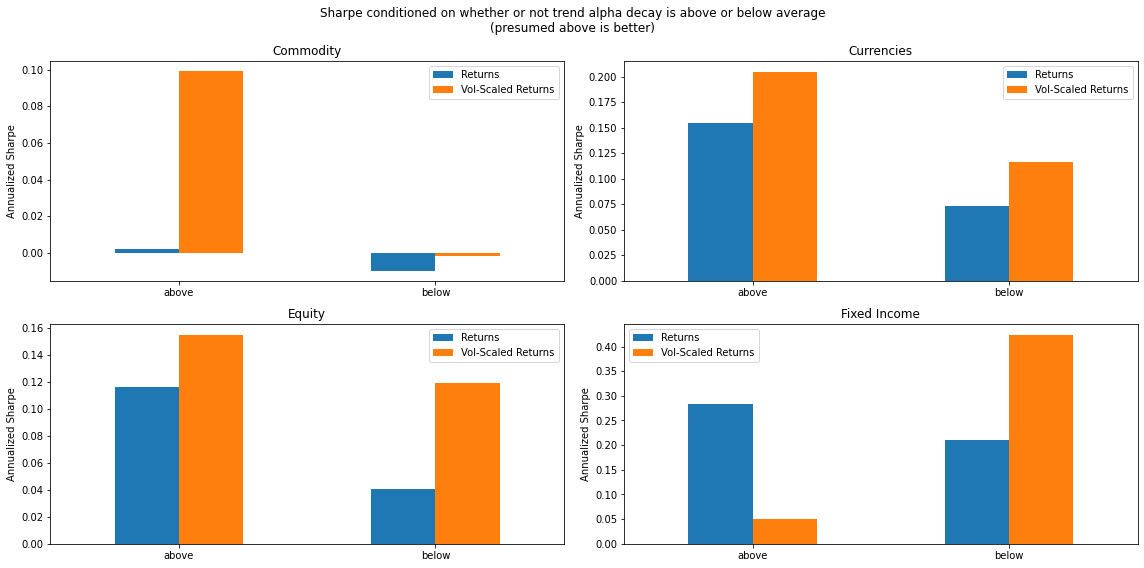

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    variables = df_sharpe.kind.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (16,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_sharpe.query(
            "kind == @variable").
            rename(columns = {"variable": ""}).
            pivot(index = "lag_group", columns = "", values = "sharpe").
            rename(columns = {
                "px_rtn" : "Returns",
                "vol_rtn": "Vol-Scaled Returns"}).
            plot(
                ax     = ax,
                title  = variable,
                kind   = "bar",
                rot    = 0,
                xlabel = "",
                ylabel = "Annualized Sharpe"))
        
    fig.suptitle("Sharpe conditioned on whether or not trend alpha decay is above or below average\n(presumed above is better)")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)